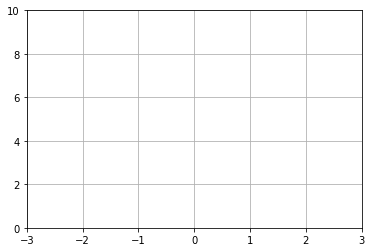

In [15]:
import numpy as np
import dynamicshelper as dh
from numpy import linalg as LA
import math
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib import animation, rc
from IPython.display import HTML, Image

''' Some key parameters for the simulation! '''
### dissipation parameters for electronic and photonic system
gam_diss_np = 0.00000 #1 #5
gam_deph_np = 0.0000

gam_diss_m = 0.00000
gam_deph = 0.0000

### Initial position, velocity, timestep, and R-step for dynamics
#ri = np.array([-0.7, -0.6])
#vi = np.array([0.0001282*1.5, 0.0001282*1.2])

ri_val = -0.6615679318398704 
vi_val = 3.33752906715916e-05
ri = np.array([ri_val])
vi = np.array([vi_val])
au_to_ps = 2.4188e-17 * 1e12
### This is the reduced mass of this rotational mode for the dynamics... in atomic units
M = 1009883

### hbar omega_c in atomic units
omc = 2.45/27.211 
### hbar g_c in atomic units
gc = 0.02/27.211


### Number of updates for dynamics
N_time = 1500000

### position displacement increment for dynamics (a.u.)
dr = 0.01 
### time displacement increment for dynamics (a.u.)
dt = 0.1

### initial polariton state
pn = 2

### array of dissipation parameters to be passed to RK4 function
gamma = np.zeros(4)
gamma[0] = 0.
gamma[1] = gam_diss_np
gamma[2] = gam_diss_m
gamma[3] = gam_diss_m+gam_diss_np



### various arrays for dynamics

time = np.zeros(N_time)
r_of_t = np.zeros((N_time,1))
hf_error_of_t = np.zeros((N_time, 1))
tot_error_of_t = np.zeros((N_time, 1))

oo = np.zeros((N_time, 1))
tt = np.zeros((N_time, 1))
v_of_t = np.zeros((N_time,1))
e_of_t = np.zeros((N_time,1))
p_of_t = np.zeros((N_time,4))

''' The following parameters and arrays pertain 
    to the polaritonic suraces!  '''
    
### array of values along the reactive coordinate R that the 
### surfaces will be explicitly evaluated at... this is in atomic units
rlist = np.linspace(-2.0, 2.0, 50)


### Htot
He = np.zeros((4,4))
Hp = np.zeros((4,4))
Hep = np.zeros((4,4))
Htot = np.zeros((4,4))
PPES = np.zeros((len(rlist),4))



''' Now let's evaluate the polaritonic PES and store the values to the PPES array! '''
Hp = dh.H_p(Hp, omc)
Hep = dh.H_ep(Hep, gc)

#### Get H_e(r) and diagonlize to get the polaritonic potential energy surfaces
for i in range(0,len(rlist)):
    r = rlist[i]
    He = dh.H_e(He, r)
    Htot = He + Hp + Hep
    tmpH = np.copy(Htot)
    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    for j in range(0,4):
        PPES[i,j] = vals[j]
        
### form spline for ground-state surface
i_spline = InterpolatedUnivariateSpline(rlist, PPES[:,1], k=3)
Fi_spline = i_spline.derivative()
  
g_spline = InterpolatedUnivariateSpline(rlist, PPES[:,0], k=3)
Fg_spline = g_spline.derivative()  

### Plot the surfaces
'''
plt.plot(rlist, 27.211*PPES[:,0], 'b')
plt.plot(rlist, 27.211*PPES[:,1], 'g')
plt.plot(rlist, 27.211*PPES[:,2], 'y')
plt.plot(rlist, 27.211*PPES[:,3], 'r')
plt.xlim(-1.5,1.5)
plt.ylim(0,10)
plt.show()
'''

### density matrix in polariton basis!
Dl = np.zeros((4,4),dtype=complex)
Dl[pn,pn] = 1.+0j


#[Ht, Dl, vec] = dh.Transform_P_to_L(ri[0], Dpl, Hp, Hep)
#print(Dl)
#HD = np.dot(Ht,Dl)
#print(Ht)


flag = 1
for i in range(0,N_time):
    #### Update nuclear coordinate first
    time[i] = i*dt
    res = dh.Erhenfest_v2(ri, vi, M, Dl, Hp, Hep, He, gamma, gam_deph, dr, dt)
    ri = res[0]
    vi = res[1]
    #if flag==1:
    #res = dh.VelocityVerlet(Fi_spline, M, ri, vi, dt)
    #hf_force = dh.HF_Force(Hp, Hep, He, ri[0], dr, Dpl)
    #res_force = dh.Dp_Force(Hp, Hep, He, ri[0], dr, D)
    #hf_error_of_t[i,:] = (hf_force-Fi_spline(ri[0]))/Fi_spline(ri[0])
    #tot_error_of_t[i,:] = (res_force+hf_force)-Fi_spline(ri[0])
    #print(" Difference between HF and spline force is ",hf_force-Fi_spline(ri[0]))
    #else:
    #res = dh.VelocityVerlet(Fg_spline, M, ri, vi, dt)

    r_of_t[i,:] = ri
    v_of_t[i,:] = vi
    #D = res[2]
    #Htot = dh.H_e(He, ri) + Hp + Hep
    #if flag==1:
    e_of_t[i,:] = res[2] #i_spline(ri)
    Dl = res[3]
    p_of_t[i,0] = np.real(Dl[0,0])
    p_of_t[i,1] = np.real(Dl[1,1])
    p_of_t[i,2] = np.real(Dl[2,2])
    p_of_t[i,3] = np.real(Dl[3,3])
    
    if (i==1240284):
        Dl = np.zeros((4,4),dtype=complex)
        Dl[0,0] = 1+0j
    
    if (ri>0.65):
        Dl = np.zeros((4,4),dtype=complex)
        Dl[0,0] = 1+0j


fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True, xlim=(-3, 3), ylim=(0, 10))
#ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
line1, = ax.plot([], [], 'o-', lw=2)
linee1, = ax.plot([], [], lw=2)
linep2, = ax.plot([], [], lw=2)
linep1, = ax.plot([], [], lw=2)
lineg0, = ax.plot([], [], lw=2)

time_template = 'time = %.1e ps'
time_text = ax.text(0.05, 0.02, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = r_of_t[i,:]#[r_of_t[i,0], r_of_t[i,1]]
    thisy = 27.211*e_of_t[i,:] #[27.211*e_of_t[i,0],27.211*e_of_t[i,1]]
    #thisx = [r_of_t[i]]
    #thisy = [27.211*e_of_t[i]]
    
    
    line.set_data(thisx, thisy)
    #thisx = [r_of_t[i]+0.1]
    #line1.set_data(thisx, thisy)
    linee1.set_data(rlist, 27.211*PPES[:,3])
    linep2.set_data(rlist, 27.211*PPES[:,2])
    linep1.set_data(rlist, 27.211*PPES[:,1])
    lineg0.set_data(rlist, 27.211*PPES[:,0])
    time_text.set_text(time_template % (i*dt * au_to_ps))
    return line, linee1, linep2, linep1, lineg0, time_text



In [2]:
rc('animation', html='html5')
!brew install imagemagick

To reinstall 7.0.9-8, run `brew reinstall imagemagick`


In [16]:
ani = animation.FuncAnimation(fig, animate, range(1, len(r_of_t),5000),
                              interval=dt, blit=True, init_func=init)
#plt.show()

ani.save('/Users/jay/CODE/PyCQED/p3.gif', writer='imagemagick', fps=60)